# Sequence Models
In this notebook, I will implement the bidirectional Gated Recurrent Unit combined with a normal Multi-layer Perception (Fully connected or Linear Layer) to classify whether a headline was true or fake.

In [12]:
from myfunctions import *
import joblib
from tqdm import tqdm
from rnn_pytorch import *

# Find and sort list of common words in a sentence based on its occurence in the sentence
def most_common_words(sent, numb_words=20):
    words = sent.split()
    wordCount = Counter(words)
    wordCount = wordCount.most_common()
    if numb_words > len(wordCount) or numb_words < 0:
        numb_words = len(wordCount)
    top_words = [x[0] for x in wordCount[:numb_words]]
    count_words = [x[1] for x in wordCount[:numb_words]]
    return top_words, count_words

# Get the embedded feature of a word from a pretrained model (Glove or Word2Vec)
def get_word_features(w, model):
    try:
        feature = model[w]
        flag = 1
    except:
        feature = np.random.uniform(-2.5, 2.5, 300)
        file1 = open("KeyError_Glove.txt","a") 
        file1.write(f'{w}\n')
        file1.close() 
        flag = 0 # Error checker
    return feature, flag

# Replace unknown words (words not in a vocabulary given) in a sentence to UNK token
def add_unknown_token(sent, vocab):
    sent_s = sent.split()
    for idx, s in enumerate(sent_s):
        if s not in vocab:
            sent_s[idx] = 'UNK'
    psent = ' '.join(sent_s)
    return psent

# Remove unknown words (words not in a vocabulary given) out of a sentence
def remove_unknown_token(sent, vocab):
    sent_s = sent.split()
    psent = [x for x in sent_s if x in vocab]
    psent = ' '.join(psent)
    return psent


In [2]:
# Load pretrain Glove model
embeddings_dict = {}
with open("../glove/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [3]:
# Read dataset
data_full = pd.read_json('fake_news.json', lines=True)
data_full = data_full.drop(columns=['article_link']) # remove link column
df_train_f, df_test = split_dataframe(data_full, test_size=0.25, seed=1509)
df_train, df_validate = split_dataframe(df_train_f, test_size=0.2, seed=1309)

# Proportion of each subsets
list_label = df_train['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TRAINING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_validate['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== VALIDATING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_test['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TESTING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

# Preprocessing
# S1 - discard symbol out of headlines
# S2 - lemmatised headline_s1
data_train = df_train
data_train['headline_s1'] = data_train.headline.apply(lambda row: remove_symbol(row))
data_train['headline_s2'] = data_train.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_train['headline_s2'] = data_train.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

data_val = df_validate
data_val['headline_s1'] = data_val.headline.apply(lambda row: remove_symbol(row))
data_val['headline_s2'] = data_val.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_val['headline_s2'] = data_val.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

data_test = df_test
data_test['headline_s1'] = data_test.headline.apply(lambda row: remove_symbol(row))
data_test['headline_s2'] = data_test.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_test['headline_s2'] = data_test.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))


===== TRAINING SAMPLES =====
Total Sample: 17171
Sarcastic: 8180 (47.64%)
Not Sarcastic: 8991 (52.36%)
===== VALIDATING SAMPLES =====
Total Sample: 4293
Sarcastic: 2045 (47.64%)
Not Sarcastic: 2248 (52.36%)
===== TESTING SAMPLES =====
Total Sample: 7155
Sarcastic: 3409 (47.65%)
Not Sarcastic: 3746 (52.35%)


# With UNK
Run the experiment in which using UNK token for unknown words

In [4]:
dt_train = data_train.copy()
dt_val = data_val.copy()

# Count the frequency of words in the training corpus
all_string = dt_train.headline_s1.tolist()
all_string_in_one = ' '.join(all_string)
all_string_in_one = all_string_in_one.lower()
list_common_words, count_words = most_common_words(all_string_in_one, numb_words=-1)

cwdf = pd.DataFrame(np.asarray(count_words),
                    columns=['count_words'])
cwdf['words'] = list_common_words

# Find the index of words appeared only once in the corpus
s = cwdf.index[cwdf.iloc[:,0] == 1].tolist()[0]
s = s + 21115 - 11476 # Only take 2000 unknown words into UNK token
common_vocab = cwdf.words[0:s].tolist()
print(f"Number of unique words remaining: {s} / {len(list_common_words)}")
print(f"Total discard (Unknown Token): {cwdf.iloc[s:,0].sum()}")

Number of unique words remaining: 21115 / 23115
Total discard (Unknown Token): 2000


In [5]:
# Convert unknown words into UNK tokens in the dataset
dt_train['preprocess'] = dt_train.headline_s1.apply(lambda row: add_unknown_token(row, common_vocab))
dt_val['preprocess'] = dt_val.headline_s1.apply(lambda row: add_unknown_token(row, common_vocab))

In [6]:
# Add padding, unknown token to the vocab
# Also add sos (start of sentence) and eos (end of sentence) to the vocab
# These tokens to indicate the position of the start and end of a sentence for the sequence model
list_vocab = ['<pad>', '<unk>'] + common_vocab + ['<sos>', '<eos>']
print(f"Total Vocabulary: {len(list_vocab)}")

Total Vocabulary: 21119


In [7]:
# Initialise weight by using pretrained Glove model
embedding_weight = np.zeros((len(list_vocab), 300)) # index is use when words is not indictionary
unknown_word = dict()
embedding_weight[1] = np.random.uniform(-2.5, 2.5, 300)
embedding_weight[-1] = np.random.uniform(-2.5, 2.5, 300)
embedding_weight[-2] = np.random.uniform(-2.5, 2.5, 300)
for idx in tqdm(range(2, len(list_vocab)-2)):
    word = list_vocab[idx]
    word_split = word.split()
    if len(word_split) == 1:
        feature, flag = get_word_features(word_split[0], embeddings_dict)
        if flag == 0: # not exist word
            unknown_word[word_split[0]] = feature
    else:
        feature = np.zeros((len(word_split), 300))
        count = 0
        for idx_w, w in enumerate(word_split):
            ft, flag = get_word_features(w, embeddings_dict)
            if flag == 0:
                if w in list(unknown_word.keys()):
                    ft = unknown_word[w]
                else:
                    unknown_word[w] = ft
            feature[idx_w] = ft
            count = count + (1-flag)
        feature[idx_w] = feature[idx_w] # + 1e-5 # avoid divided by 0    
        feature = np.mean(feature, axis=0) # equal to divided by len(word_split) or count (not recommend)
              
    embedding_weight[idx] = feature

100%|██████████| 21115/21115 [00:00<00:00, 233500.39it/s]


In [8]:
# Create Dataset Pytorch datastructure
datasetTrain = EmbeddingDataset(dt_train, col_name='preprocess', list_vocab=list_vocab)
datasetVal = EmbeddingDataset(dt_val, col_name='preprocess', list_vocab=list_vocab)

In [10]:
# Declare the model and Train
model_gru = ModelRNN(vocab_size=len(list_vocab), datasetTrain=datasetTrain, datasetVal=datasetVal,
                   init_weight=embedding_weight, batch_size=512, optimizer_choice='adam', 
                   init_lr=0.001, mlp_layers_dim=[512,1], rnn_hidden_size=256, rnn_num_layers=3, bidirectional=True, 
                   weight_decay=1e-5, dropout=0.75, batchnorm=True, checkpoint=None, model_name='GRU_UNK_Raw', grad_clip=2)

model_gru.train(numb_epoch=50)

TRAIN FROM SCRATCH
Training 0/49
Total iteration: 34
Epoch 1/50 [16122020-151045] [SAVE]
AccVal: 0.8094572559981364
AUCVal: 0.8888513778071679
Precision: 0.7772254943847656
Recall: 0.8410757780075073
F1Val: 0.8078910256439313
LossVal: 0.4283977548281352
LossTrain: 0.5761143845670363
----------

Training 1/49
Total iteration: 34
Epoch 2/50 [16122020-151106] [SAVE]
AccVal: 0.8262287444677382
AUCVal: 0.9194436347658119
Precision: 0.8854599595069885
Recall: 0.7295843362808228
F1Val: 0.7999999686735142
LossVal: 0.41329096423255074
LossTrain: 0.3778732752098757
----------

Training 2/49
Total iteration: 34
Epoch 3/50 [16122020-151127] [SAVE]
AccVal: 0.8436990449569066
AUCVal: 0.9198750967988933
Precision: 0.844188392162323
Recall: 0.8239609003067017
F1Val: 0.8339520396986987
LossVal: 0.3659750256273482
LossTrain: 0.32704005916328993
----------

Training 3/49
Total iteration: 34
Epoch 4/50 [16122020-151150] [SAVE]
AccVal: 0.8590729093873748
AUCVal: 0.9362734818888183
Precision: 0.833642244338

KeyboardInterrupt: 

In [12]:
# Load pretrained model and evaluate on train / validate set
dataloader = make_EmbeddingDataLoader(datasetTrain, batch_size=1024)
model_gru = ModelRNN(vocab_size=len(list_vocab), datasetTrain=datasetTrain, datasetVal=datasetVal,
                   init_weight=embedding_weight, batch_size=512, optimizer_choice='adam', 
                   init_lr=0.001, mlp_layers_dim=[512,1], rnn_hidden_size=256, rnn_num_layers=3, bidirectional=True, 
                   weight_decay=1e-5, dropout=0.75, batchnorm=True, 
                   checkpoint='Checkpoint/GRU_UNK_Raw-16122020-151023.pth.tar',
                   model_name='GRU_UNK_Raw', grad_clip=2)
model_gru.load_trained_model()
model_gru.evaluate(dataloader)

LOAD PRETRAINED MODEL AT GRU_UNK_Raw-16122020-151023.pth.tar


{'accuracy': 0.9605730592277677,
 'precision': 0.9665465,
 'recall': 0.95012224,
 'f1': 0.958264015391339,
 'tp': 7772,
 'tn': 8722,
 'fp': 269,
 'fn': 408,
 'auc': 0.989733668740732}

# Without UNK
Run the experiment in which NOT using UNK token but remove unknown words

In [4]:
dt_train = data_train.copy()
dt_val = data_val.copy()

# Count the frequency of words in the training corpus
all_string = dt_train.headline_s1.tolist()
all_string_in_one = ' '.join(all_string)
all_string_in_one = all_string_in_one.lower()
list_common_words, count_words = most_common_words(all_string_in_one, numb_words=-1)

cwdf = pd.DataFrame(np.asarray(count_words),
                    columns=['count_words'])
cwdf['words'] = list_common_words

# Find the index of words appeared only once in the training corpus
# Only use words appearing more than once in the training corpus
s = cwdf.index[cwdf.iloc[:,0] == 1].tolist()[0]
# s = s + 21115 - 11476
common_vocab = cwdf.words[0:s].tolist()
print(f"Number of unique words remaining: {s} / {len(list_common_words)}")
print(f"Total discard (Unknown Token): {cwdf.iloc[s:,0].sum()}")

Number of unique words remaining: 11476 / 23115
Total discard (Unknown Token): 11639


In [5]:
# remove unknown words in the dataset
dt_train['preprocess'] = dt_train.headline_s1.apply(lambda row: remove_unknown_token(row, common_vocab))
dt_val['preprocess'] = dt_val.headline_s1.apply(lambda row: remove_unknown_token(row, common_vocab))

In [6]:
# Add padding token to the vocab
# Also add sos (start of sentence) and eos (end of sentence) to the vocab
# These tokens to indicate the position of the start and end of a sentence for the sequence model
list_vocab = ['<pad>'] + common_vocab + ['<sos>', '<eos>']
print(f"Total Vocabulary: {len(list_vocab)}")

Total Vocabulary: 11479


In [7]:
# initialise weight by Glove model
embedding_weight = np.zeros((len(list_vocab), 300)) # index is use when words is not indictionary
unknown_word = dict()
embedding_weight[-1] = np.random.uniform(-2.5, 2.5, 300)
embedding_weight[-2] = np.random.uniform(-2.5, 2.5, 300)
for idx in tqdm(range(1, len(list_vocab)-2)):
    word = list_vocab[idx]
    word_split = word.split()
    if len(word_split) == 1:
        feature, flag = get_word_features(word_split[0], embeddings_dict)
        if flag == 0: # not exist word
            unknown_word[word_split[0]] = feature
    else:
        feature = np.zeros((len(word_split), 300))
        count = 0
        for idx_w, w in enumerate(word_split):
            ft, flag = get_word_features(w, embeddings_dict)
            if flag == 0:
                if w in list(unknown_word.keys()):
                    ft = unknown_word[w]
                else:
                    unknown_word[w] = ft
            feature[idx_w] = ft
            count = count + (1-flag)
        feature[idx_w] = feature[idx_w] # + 1e-5 # avoid divided by 0    
        feature = np.mean(feature, axis=0) # equal to divided by len(word_split) or count (not recommend)
              
    embedding_weight[idx] = feature

100%|██████████| 11476/11476 [00:00<00:00, 368043.50it/s]


In [8]:
# Create Dataset Pytorch datastructure
datasetTrain = EmbeddingDataset(dt_train, col_name='preprocess', list_vocab=list_vocab)
datasetVal = EmbeddingDataset(dt_val, col_name='preprocess', list_vocab=list_vocab)

In [10]:
# Declare model and train
model_gru = ModelRNN(vocab_size=len(list_vocab), datasetTrain=datasetTrain, datasetVal=datasetVal,
                   init_weight=embedding_weight, batch_size=1024, optimizer_choice='adam', 
                   init_lr=0.001, mlp_layers_dim=[512, 1], rnn_hidden_size=512, rnn_num_layers=3, bidirectional=True, 
                   weight_decay=1e-5, dropout=0.75, batchnorm=True, checkpoint=None, model_name='GRU_Raw', grad_clip=2)

model_gru.train(numb_epoch=50)

TRAIN FROM SCRATCH
Training 0/49
Total iteration: 17
Epoch 1/50 [16122020-160253] [SAVE]
AccVal: 0.7391101793617517
AUCVal: 0.8703749706340436
Precision: 0.6605345606803894
Recall: 0.9305623769760132
F1Val: 0.7726350536419755
LossVal: 0.5233440041542053
LossTrain: 0.6474642438047072
----------

Training 1/49
Total iteration: 17
Epoch 2/50 [16122020-160306] [SAVE]
AccVal: 0.7437689261588633
AUCVal: 0.905019294520965
Precision: 0.6596823334693909
Recall: 0.9545232057571411
F1Val: 0.7801758291267211
LossVal: 0.7253247022628784
LossTrain: 0.4300495701677659
----------

Training 2/49
Total iteration: 17
Epoch 3/50 [16122020-160318] [SAVE]
AccVal: 0.8127183787561146
AUCVal: 0.9210242845582923
Precision: 0.7463279366493225
Recall: 0.9193153977394104
F1Val: 0.8238387531825331
LossVal: 0.5589284777641297
LossTrain: 0.32567404648836923
----------

Training 3/49
Total iteration: 17
Epoch 4/50 [16122020-160331] [SAVE]
AccVal: 0.8551129746098299
AUCVal: 0.9299484899372655
Precision: 0.8472425341606

KeyboardInterrupt: 

In [12]:
# Load pretrained model and evaluate on train / validate set
dataloader = make_EmbeddingDataLoader(datasetTrain, batch_size=1024)
model_gru = ModelRNN(vocab_size=len(list_vocab), datasetTrain=datasetTrain, datasetVal=datasetVal,
                   init_weight=embedding_weight, batch_size=1024, optimizer_choice='adam', 
                   init_lr=0.001, mlp_layers_dim=[512, 1], rnn_hidden_size=512, rnn_num_layers=3, bidirectional=True, 
                   weight_decay=1e-5, dropout=0.75, batchnorm=True, 
                   checkpoint='Checkpoint/GRU_Raw-16122020-160240.pth.tar', 
                   model_name='GRU_Raw', grad_clip=2)

model_gru.load_trained_model()
model_gru.evaluate(dataloader)

LOAD PRETRAINED MODEL AT Checkpoint/GRU_Raw-16122020-160240.pth.tar


{'accuracy': 0.9174771416923884,
 'precision': 0.9149589,
 'recall': 0.91149145,
 'f1': 0.913221882553754,
 'tp': 7456,
 'tn': 8298,
 'fp': 693,
 'fn': 724,
 'auc': 0.9720502355112515}

# Evaluation on Test set
Evaluate the best model on the test set

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [4]:
dt_train = data_train.copy()
dt_test = data_test.copy()

# Count the frequency of words in the training corpus
all_string = dt_train.headline_s1.tolist()
all_string_in_one = ' '.join(all_string)
all_string_in_one = all_string_in_one.lower()
list_common_words, count_words = most_common_words(all_string_in_one, numb_words=-1)

cwdf = pd.DataFrame(np.asarray(count_words),
                    columns=['count_words'])
cwdf['words'] = list_common_words

# Find the index of words appeared only once in the corpus
s = cwdf.index[cwdf.iloc[:,0] == 1].tolist()[0]
s = s + 21115 - 11476 # Only take 2000 unknown words into UNK token
common_vocab = cwdf.words[0:s].tolist()
print(f"Number of unique words remaining: {s} / {len(list_common_words)}")
print(f"Total discard (Unknown Token): {cwdf.iloc[s:,0].sum()}")

Number of unique words remaining: 21115 / 23115
Total discard (Unknown Token): 2000


In [5]:
# Convert unknown words into UNK tokens
dt_test['preprocess'] = dt_test.headline_s1.apply(lambda row: add_unknown_token(row, common_vocab))

# Add padding, unknown token to the vocab
# Also add sos (start of sentence) and eos (end of sentence) to the vocab
# These tokens to indicate the position of the start and end of a sentence for the sequence model
list_vocab = ['<pad>', '<unk>'] + common_vocab + ['<sos>', '<eos>']
print(f"Total Vocabulary: {len(list_vocab)}")

Total Vocabulary: 21119


## Metrics on Test set
Load model and calculate metrics score

In [6]:
# Create Dataset Pytorch datastructure
datasetTest = EmbeddingDataset(dt_test, col_name='preprocess', list_vocab=list_vocab)

# Load pretrained model and evaluate on test set
dataloader = make_EmbeddingDataLoader(datasetTest, batch_size=1024)
model_gru = ModelRNN(vocab_size=len(list_vocab), datasetTrain=datasetTest, datasetVal=None,
                   init_weight=None, batch_size=512, optimizer_choice='adam', 
                   init_lr=0.001, mlp_layers_dim=[512,1], rnn_hidden_size=256, rnn_num_layers=3, bidirectional=True, 
                   weight_decay=1e-5, dropout=0.75, batchnorm=True, 
                   checkpoint='Checkpoint/GRU_UNK_Raw-16122020-151023.pth.tar',
                   model_name='GRU_UNK_Raw', grad_clip=2)

model_gru.load_trained_model()
model_gru.evaluate(dataloader)

LOAD PRETRAINED MODEL AT Checkpoint/GRU_UNK_Raw-16122020-151023.pth.tar


{'accuracy': 0.86722571628232,
 'precision': 0.86756355,
 'recall': 0.85127604,
 'f1': 0.8593425939234797,
 'tp': 2902,
 'tn': 3303,
 'fp': 443,
 'fn': 507,
 'auc': 0.9400768857662508}

## Detail Prediction
Making the prediction alone

In [7]:
# Making prediction, pred is just the probability of is_sarcastic
pred, label = model_gru.predict(dataloader)

In [8]:
# Final prediction with binary
pred_binary = np.copy(pred) 
pred_binary[pred_binary>=0.5] = 1
pred_binary[pred_binary!=1] = 0

In [9]:
pred_binary

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [10]:
label

array([1., 1., 1., ..., 1., 0., 0.], dtype=float32)

In [15]:
conf_matrix = confusion_matrix(label, pred_binary)
conf_matrix

array([[3303,  443],
       [ 507, 2902]])

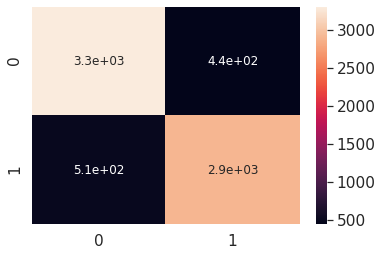

In [18]:
df_cm = pd.DataFrame(conf_matrix, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

plt.show()


In [21]:
# generate a no skill prediction (majority class)
random_pred = [0 for _ in range(len(label))]
# calculate scores
random_auc = roc_auc_score(label, random_pred)
model_auc = roc_auc_score(label, pred)

# calculate roc curves
random_fpr, random_tpr, _ = roc_curve(label, random_pred)
model_fpr, model_tpr, _ = roc_curve(label, pred)

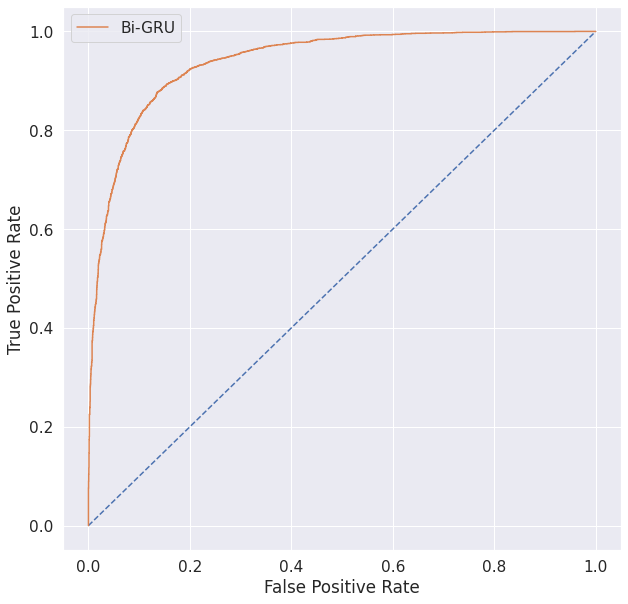

In [47]:
plt.figure(figsize=(10,10))
# plot the roc curve for the model
plt.plot(random_fpr, random_tpr, linestyle='--')
plt.plot(model_fpr, model_tpr, label='Bi-GRU')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig('../figures/roc_curve.png', bbox_inches='tight', transparent=False, dpi=500)
# show the plot
plt.show()